# TRAINING NOTEBOOK

## Environment

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/notebooks'):
    main_path = p[:-len('/notebooks')]
if sys.path[0].endswith('/techdoc/content'):
    main_path = p[:-len('/techdoc/content')]
    
# Windows OS
if sys.path[0].endswith('\\notebooks'): 
    main_path = p[:-len('\\notebooks')]
if sys.path[0].endswith('\\techdoc\content'): 
    main_path = p[:-len('\\techdoc\content')]

sys.path[0] = main_path

In [3]:
import gc, itertools
from termcolor import colored
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from src import (config, describe_data, features,
                 preprocess, training)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# DATA PREPARATION

In [4]:
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Submission: (804, 11)


In [5]:
# ===== MODEL SAMPLES ======
train = metadata[metadata.split == 'train'].copy().reset_index(drop=True)
print(f'TRAIN: {train.shape}')

valid = metadata[metadata.split == 'val'].copy().reset_index(drop=True)
print(f'VALID: {valid.shape}')

test = metadata[metadata.split == 'test'].copy().reset_index(drop=True)
print(f'TEST: {test.shape}')

TRAIN: (766, 5)
VALID: (293, 5)
TEST: (511, 5)


In [6]:
# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
all_test_files = valid_files.copy()
all_test_files.update(test_files)

ion_list = list(np.arange(0,100,1.0))

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


# FEATURE ENGINEERING

In the benchmark notebook the features are discretized into bins of 100 degrees.

In [ ]:
#TODO How long does it take for temperature to rise to certain level where we get abundance?
#TODO How to account for the non-linear diferences of time vs temp?
#TODO Each type of ion as a feature, make a matrix and append to the training dataset
#TODO Max value of abundance of each ion - take temp reading and time - or duration
#TODO How to define characteristic of peaks in ion abundances; temp at which they occur, the shape of peaks (height, width, area)
#TODO How to deal with overlapping peaks
#TODO Number of peaks, size of the peaks
#TODO Can we do some target encoding?

**Average temperature per sample**

In [ ]:
# Average temperature per sample
train = features.avg_temp_sample(train, train_files)
valid = features.avg_temp_sample(valid, valid_files)
test = features.avg_temp_sample(test, test_files)

**Compute min and max temp for all available samples, including the ion types**

In [ ]:
# Get min/max temperature values and unique ion list
# Preprocess the data to remove noise before calculation
min_temp, max_temp, ion_list = preprocess.compute_min_max_temp_ion(metadata)
print(colored(f'Min temp = {min_temp}; Max temp = {max_temp}', 'blue'))
print(colored(f'Number of unqiue ions: {len(ion_list)}', 'blue'))

100%|██████████| 1570/1570 [01:35<00:00, 16.51it/s]

Min temp = -63.563; Max temp = 1484.13
Number of unqiue ions: 99


## Max relative abundance per temp bin and ion type

Bin the temp from min to max in intervals of 100 degrees and combine with the ion type i.e. `m/z`. For each combination compute the maximum relative abundance.

In [9]:
# ===== TRAIN SAMPLE =====
print(f'Number of all test files: {len(train_files)}')
fts_maxrelabund_tempion = features.features_iontemp_abun(metadata, train_files)
print(f'Val-Test features: {fts_maxrelabund_tempion.shape}')
fts_maxrelabund_tempion = fts_maxrelabund_tempion.replace(np.nan, 0)

Number of all test files: 766
Number of samples: 766
Val-Test features: (766, 1584)


In [14]:
# ===== VALID & TEST SAMPLE =====
print(f'Number of all test files: {len(all_test_files)}')
fts_maxrelabund_tempion_VT = features.features_iontemp_abun(metadata, all_test_files)
print(f'Val-Test features: {fts_maxrelabund_tempion_VT.shape}')
fts_maxrelabund_tempion_VT = fts_maxrelabund_tempion_VT.replace(np.nan,0)

Number of all test files: 804
Number of samples: 804
Val-Test features: (804, 1584)


## Duration to max temperature per ion type

Ion types are presented in column, rows are samples and values are time in seconds to max abundance. We should also record at what temperature this happens.

In [137]:
# ===== TRAIN SAMPLE =====
fts_dur_maxabund_ion = features.features_ion_duration_maxtemp(metadata, train_files, ion_list)
print(f'Features: {fts_dur_maxabund_ion.shape}')
#TODO Fix the warnings

 13%|█▎        | 99/766 [00:39<04:34,  2.43it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 13%|█▎        | 100/766 [00:39<04:19,  2.56it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 13%|█▎        | 101/766 [00:40<04:17,  2.59it/s]/Users/itacdonev/Documents/P

Features: (766, 99)


In [139]:
# ===== VALID & TEST SAMPLE =====
fts_dur_maxabund_ion_VT = features.features_ion_duration_maxtemp(metadata, all_test_files, ion_list)
print(f'Features: {fts_dur_maxabund_ion.shape}')

 12%|█▏        | 99/804 [00:37<05:14,  2.24it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 12%|█▏        | 100/804 [00:37<05:27,  2.15it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 13%|█▎        | 101/804 [00:38<05:26,  2.15it/s]/Users/itacdonev/Documents/P

Features: (766, 99)


## Combine mx relative abundance and duration

In [153]:
# ===== TRAIN SAMPLE =====
combo_maxabund_dur = pd.concat([fts_maxrelabund_tempion, fts_dur_maxabund_ion], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_dur.shape)

(766, 1683)


In [155]:
# ===== VALID & TEST SAMPLE =====
combo_maxabund_dur_VT = pd.concat([fts_maxrelabund_tempion_VT, fts_dur_maxabund_ion_VT], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_dur_VT.shape)

(804, 1683)


## Analysis of time series

- Percentage change in relative abundance per temp-ion - For each temperature(bin)-ion combination compute the change in relativen abundance.
- find number of peaks
- area under the curve for each ion type

In [7]:
ht = preprocess.get_sample(metadata,0)
ht = preprocess.preprocess_samples(ht)

In [8]:
# ===== TRAIN SAMPLE =====
ht['pct_change_abund'] = ht.groupby('m/z')['abun_minsub_scaled'].pct_change(periods=4).fillna(0)
proba = ht[ht['m/z'] == 18.0].sort_values(by=['m/z', 'time'])
proba.head(25)

,time,temp,m/z,abundance,abundance_minsub,abun_minsub_scaled,pct_change_abund
18,0.000,35.289,18.0,2.591863e-09,4.739700e-11,0.001415,0.000000
218,10.251,35.420,18.0,2.590188e-09,4.572200e-11,0.001365,0.000000
418,20.519,35.680,18.0,2.588703e-09,4.423700e-11,0.001320,0.000000
618,30.791,36.329,18.0,2.578697e-09,3.423100e-11,0.001022,0.000000
818,41.044,37.293,18.0,2.570629e-09,2.616300e-11,0.000781,-0.448003
1018,51.318,38.496,18.0,2.568906e-09,2.444000e-11,0.000730,-0.465465
1218,61.569,39.940,18.0,2.559116e-09,1.465000e-11,0.000437,-0.668829
1418,71.835,41.438,18.0,2.568667e-09,2.420100e-11,0.000722,-0.293009
1618,82.079,43.072,18.0,2.575154e-09,3.068800e-11,0.000916,0.172954
1818,92.344,44.650,18.0,2.576160e-09,3.169400e-11,0.000946,0.296809


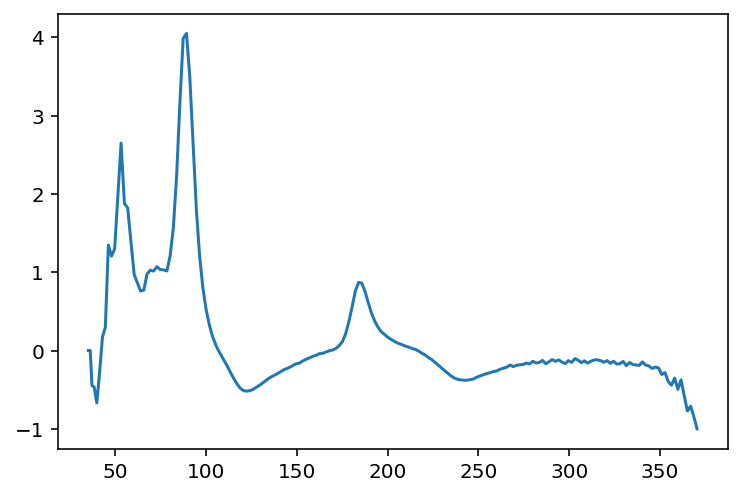

In [9]:
plt.plot(proba['temp'], proba['pct_change_abund'])
plt.show()

**ANALYSE PEAKS**

- add ion_cnt_peaks
- add time to peak
- first bigger than second if more than one

Refernces:  
- [finding peaks in MS data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631518/)
- [SO comment on scipy](https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy)

In [10]:
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import auc

In [11]:
htt = ht[ht['m/z'] == 9.0].copy()
htt['abun_minsub_scaled_filtered'] = gaussian_filter1d(htt['abun_minsub_scaled'], sigma=4)

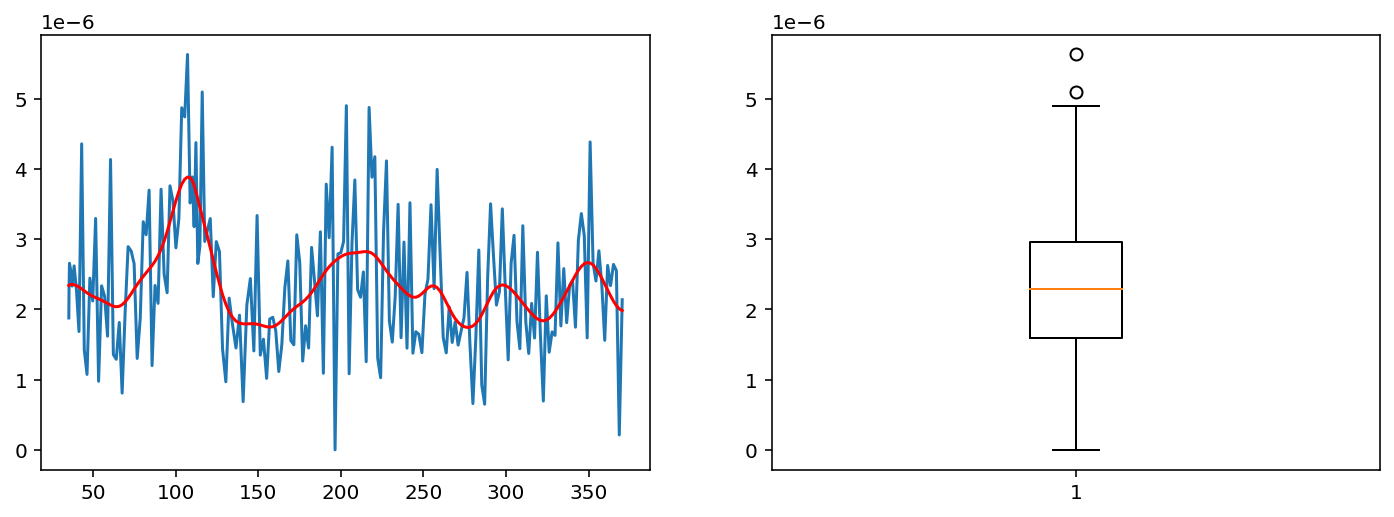

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled'])
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled_filtered'], color='red')
plt.subplot(1, 2, 2); plt.boxplot(htt['abun_minsub_scaled'])
plt.show()

In [13]:
ion_abund_median = htt['abun_minsub_scaled_filtered'].mean()
print(ion_abund_median)
peaks, _ = find_peaks(htt['abun_minsub_scaled_filtered'], prominence=ion_abund_median)
#peaks_s = find_peaks_cwt(htt['abun_minsub_scaled'], noise_perc=0.1)
print(f'Peak idx: {peaks}') # indexes where peaks are found
#print(f'Peak idx: {peaks_s}') # indexes where peaks are found
# Get temp values for peaks
for i in peaks:
    print(htt.iloc[i]['temp'])
    
# Compute area under the curve
xx = htt['temp']
yy = htt['abun_minsub_scaled']
print(f'Area under the curve: {np.round(auc(xx,yy),5)}')

2.360300874910426e-06
Peak idx: []
Area under the curve: 0.00078


In [17]:
# ht is sample S0000
ion_peaks_cnt = {}

for ion in ion_list:
    ion_peaks_info = []
    temp_dt = ht[ht['m/z'] == ion].copy()
    temp_dt['abun_minsub_scaled_filtered'] = gaussian_filter1d(temp_dt['abun_minsub_scaled'], 
                                                               sigma=4)
    med = temp_dt['abun_minsub_scaled_filtered'].median()
    
    peaks, _ = find_peaks(temp_dt['abun_minsub_scaled_filtered'], prominence=med)
    ion_peaks_info.append(len(peaks))
    
    peak_temp = []
    peak_time = []
    peak_abund = []
    for i in peaks:
        tm = temp_dt.iloc[i]['time']; peak_time.append(tm) 
        t = temp_dt.iloc[i]['temp']; peak_temp.append(t)
        a = temp_dt.iloc[i]['abun_minsub_scaled']; peak_abund.append(a)
    
    if len(peak_time)>0 and len(peak_temp)>0 and len(peak_abund)>0:
        peak_time = max(peak_time)
        peak_temp = max(peak_temp)
        peak_abund = max(peak_abund)
    else: 
        peak_time, peak_temp, peak_abund = 0, 0, 0
        
    # Compute AUC
    if not temp_dt.empty:
        area_abund = np.round(auc(temp_dt['temp'],temp_dt['abun_minsub_scaled']),5)
    else: area_abund = 0
    
    # Add values
    ion_peaks_info.append(peak_time)
    ion_peaks_info.append(peak_temp)
    ion_peaks_info.append(peak_abund)
    ion_peaks_info.append(area_abund)
        
    ion_peaks_cnt[ion] = ion_peaks_info
    
ion_peaks_cnt

{0.0: [2, 1057.428, 211.921, 0.004470519521099676, 0.23782],
 1.0: [2, 1057.428, 211.921, 0.0038136619698634225, 0.21449],
 2.0: [2, 1077.961, 215.359, 0.0005123556598944679, 0.03806],
 3.0: [0, 0, 0, 0, 0.03961],
 4.0: [0, 0, 0, 0, 0],
 5.0: [1, 441.332, 105.458, 2.7124405884896144e-05, 0.00385],
 6.0: [1, 431.06, 103.666, 2.6798565682232838e-06, 0.00084],
 7.0: [1, 420.772, 101.931, 4.246513336702777e-06, 0.0006],
 8.0: [0, 0, 0, 0, 0.00104],
 9.0: [0, 0, 0, 0, 0.00078],
 10.0: [0, 0, 0, 0, 0.00082],
 11.0: [0, 0, 0, 0, 0.00084],
 12.0: [2, 1796.886, 340.303, 0.00014395089424569068, 0.01731],
 13.0: [0, 0, 0, 0, 0.00402],
 14.0: [0, 0, 0, 0, 0.38302],
 15.0: [2, 1077.961, 215.359, 0.00023548035042686977, 0.01611],
 16.0: [2, 1057.428, 211.921, 0.024268038610332734, 1.2762],
 17.0: [2, 1057.428, 211.921, 0.2731880287813971, 13.32941],
 18.0: [2, 1057.428, 211.921, 0.9858801583853227, 48.16406],
 19.0: [2, 1088.232, 217.115, 0.006349436036159307, 0.46937],
 20.0: [2, 1057.428, 211.921,

In [27]:
new_cols = ['m/z','peak_cnt', 'peak_time', 'peak_temp', 'peak_abund', 'abund_area']
ion_peaks_stats = pd.DataFrame(ion_peaks_cnt)
ion_peaks_stats = ion_peaks_stats.T
ion_peaks_stats.reset_index(inplace=True)
ion_peaks_stats.columns = new_cols
ion_peaks_stats['sample_id'] = 'S0000'
ion_peaks_stats

,m/z,peak_cnt,peak_time,peak_temp,peak_abund,abund_area,sample_id
0,0.0,2.0,1057.428,211.921,0.004471,0.23782,S0000
1,1.0,2.0,1057.428,211.921,0.003814,0.21449,S0000
2,2.0,2.0,1077.961,215.359,0.000512,0.03806,S0000
3,3.0,0.0,0.000,0.000,0.000000,0.03961,S0000
4,4.0,0.0,0.000,0.000,0.000000,0.00000,S0000
...,...,...,...,...,...,...,...
95,95.0,0.0,0.000,0.000,0.000000,0.00049,S0000
96,96.0,0.0,0.000,0.000,0.000000,0.00074,S0000
97,97.0,0.0,0.000,0.000,0.000000,0.00052,S0000
98,98.0,0.0,0.000,0.000,0.000000,0.00050,S0000


In [28]:
proba = ion_peaks_stats.pivot(index='sample_id', columns="m/z")
proba

peak_cnt                                               ...  \
m/z           0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0   ...   
sample_id                                                        ...   
S0000          2.0  2.0  2.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  ...   

          abund_area                                                        \
m/z             90.0     91.0     92.0     93.0     94.0     95.0     96.0   
sample_id                                                                    
S0000        0.00058  0.00063  0.00052  0.00045  0.00067  0.00049  0.00074   

                                     
m/z           97.0    98.0     99.0  
sample_id                            
S0000      0.00052  0.0005  0.00058  

[1 rows x 500 columns]

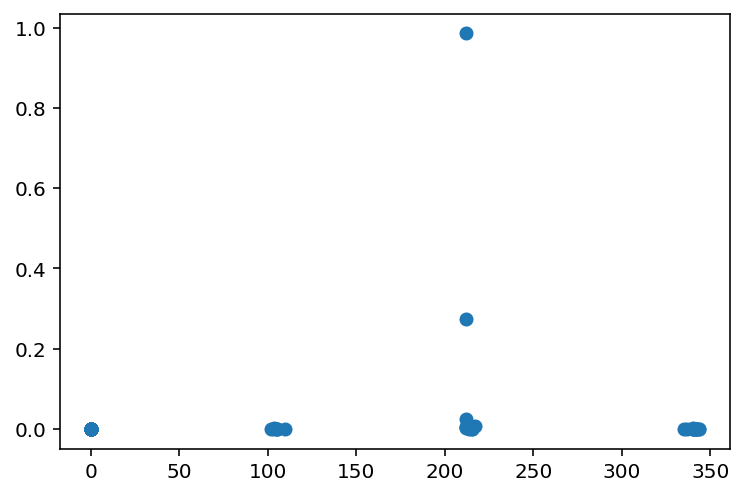

In [20]:
plt.scatter(ion_peaks_stats['peak_temp'], ion_peaks_stats['peak_abund'])
plt.show()

**ANALYZE THE ABUNDANCE CURVE**

# MODELS

In [21]:
# Data frame to save local CV results
models_log_loss = pd.DataFrame(index=target_labels_list)

## Logistic Regression - Benchmark

In [16]:
# ===== TRAIN MODEL - CROSS VALIDATION =====
clf = LogisticRegression(penalty="l1",solver="liblinear", 
                         C=10, random_state=config.RANDOM_SEED)
logloss_LR = training.trainCV_label(X = fts_maxrelabund_tempion, 
                                 df_y = train_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['LRbench'] = models_log_loss.index.map(logloss_LR)

# Print results
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_LR.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_LR

Average Log Loss: 0.2759
Log Loss per Label:


{'basalt': 0.27678260590883075,
 'carbonate': 0.2612545003933846,
 'chloride': 0.2842979960325033,
 'iron_oxide': 0.3824699336087238,
 'oxalate': 0.004059239489520996,
 'oxychlorine': 0.2991500982787292,
 'phyllosilicate': 0.4074758334090647,
 'silicate': 0.35168474392654814,
 'sulfate': 0.34471883287139204,
 'sulfide': 0.14713584783404984}

In [17]:
# ===== TRAIN FULL MODEL ===== 
clf_LRr = training.train_full_model(X = fts_maxrelabund_tempion,
                                    df_y = train_labels,
                                    target = target_labels_list,
                                    model_algo = 'LR')

In [18]:
# ===== PREDICT SUBMISSION =====
submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_LRr:
    clf = clf_LRr[target]
    submission[target] = clf.predict_proba(fts_maxrelabund_tempion_VT)[:,1]

# ===== SAVE SUBMISSION ===== 
submission.to_csv(config.MODELS_DIR + 'LRr.csv')

submission.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,1.868003e-07,0.000062,0.000004,1.125625e-07,0.000052,0.000090,8.296115e-08,0.998771,0.000002,0.000002
S0767,2.259753e-01,0.261281,0.007587,3.353358e-01,0.000132,0.226904,1.458527e-02,0.879255,0.057940,0.009740
S0768,5.743717e-01,0.508643,0.000804,2.181478e-01,0.000763,0.277165,8.997608e-01,0.685684,0.249768,0.002388
S0769,1.895572e-02,0.092020,0.042351,7.053178e-02,0.000083,0.977360,1.079748e-01,0.086535,0.370443,0.003093
S0770,8.417039e-04,0.008442,0.048491,3.099149e-01,0.000358,0.862539,5.699419e-01,0.003204,0.001448,0.019214


## XGBoost

- numerical data needs to be scaled
- categorical data needs to be encoded

## XGBoost - optimized

- numerical data needs to be scaled
- categorical data needs to be encoded

In [ ]:
#TODO Finish
params = {
    'learning_rate': 0.1,
}

In [ ]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss',
                        **params)
print(clf)
logloss_XGB = training.trainCV_label(X = fts_maxrelabund_tempion, 
                                 df_y = train_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost'] = models_log_loss.index.map(logloss_XGB)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [ ]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGB.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGB

Average Log Loss: 0.1934
Log Loss per Label:


{'basalt': 0.22565078102787242,
 'carbonate': 0.13225618815649615,
 'chloride': 0.22720553328986837,
 'iron_oxide': 0.254578396456081,
 'oxalate': 0.027906252811262605,
 'oxychlorine': 0.20850854126821824,
 'phyllosilicate': 0.29730870486992084,
 'silicate': 0.2575651139000811,
 'sulfate': 0.2245971262183839,
 'sulfide': 0.07831794841140914}

In [ ]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = fts_maxrelabund_tempion,
                                    df_y = train_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB')

# ===== PREDICT SUBMISSION =====
submission_xgb = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb[target] = clf.predict_proba(fts_maxrelabund_tempion_VT)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb.to_csv(config.MODELS_DIR + 'XGB.csv')

submission_xgb.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.001594,0.000783,0.001304,0.001212,0.000931,0.002346,0.005057,0.351225,0.002165,0.000529
S0767,0.021761,0.025478,0.000169,0.004258,0.000568,0.002428,0.024791,0.638068,0.004897,0.000078
S0768,0.623543,0.232856,0.000180,0.000743,0.001106,0.002148,0.477008,0.983860,0.035161,0.000087
S0769,0.000873,0.000929,0.005847,0.016401,0.000568,0.975590,0.012908,0.000355,0.975510,0.001122
S0770,0.000576,0.000209,0.000861,0.467206,0.001348,0.998972,0.990033,0.000290,0.001139,0.000158


In [24]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss')
logloss_XGB = training.trainCV_label(X = fts_maxrelabund_tempion, 
                                 df_y = train_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost'] = models_log_loss.index.map(logloss_XGB)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [25]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGB.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGB

Average Log Loss: 0.1934
Log Loss per Label:


{'basalt': 0.22565078102787242,
 'carbonate': 0.13225618815649615,
 'chloride': 0.22720553328986837,
 'iron_oxide': 0.254578396456081,
 'oxalate': 0.027906252811262605,
 'oxychlorine': 0.20850854126821824,
 'phyllosilicate': 0.29730870486992084,
 'silicate': 0.2575651139000811,
 'sulfate': 0.2245971262183839,
 'sulfide': 0.07831794841140914}

In [26]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = fts_maxrelabund_tempion,
                                    df_y = train_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB')

# ===== PREDICT SUBMISSION =====
submission_xgb = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb[target] = clf.predict_proba(fts_maxrelabund_tempion_VT)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb.to_csv(config.MODELS_DIR + 'XGB.csv')

submission_xgb.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.001594,0.000783,0.001304,0.001212,0.000931,0.002346,0.005057,0.351225,0.002165,0.000529
S0767,0.021761,0.025478,0.000169,0.004258,0.000568,0.002428,0.024791,0.638068,0.004897,0.000078
S0768,0.623543,0.232856,0.000180,0.000743,0.001106,0.002148,0.477008,0.983860,0.035161,0.000087
S0769,0.000873,0.000929,0.005847,0.016401,0.000568,0.975590,0.012908,0.000355,0.975510,0.001122
S0770,0.000576,0.000209,0.000861,0.467206,0.001348,0.998972,0.990033,0.000290,0.001139,0.000158


## XGBoost - duration

In [144]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss')
logloss_XGB_dur = training.trainCV_label(X = fts_dur_maxabund_ion, 
                                 df_y = train_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost_dur'] = models_log_loss.index.map(logloss_XGB_dur)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [145]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGB_dur.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGB_dur

Average Log Loss: 0.2984
Log Loss per Label:


{'basalt': 0.34556434985473283,
 'carbonate': 0.3039762745213908,
 'chloride': 0.35030911804592496,
 'iron_oxide': 0.3612019024268693,
 'oxalate': 0.054180436207662774,
 'oxychlorine': 0.25880992177133333,
 'phyllosilicate': 0.4233393864763624,
 'silicate': 0.4181880998372816,
 'sulfate': 0.3117083685347533,
 'sulfide': 0.15627469664609736}

In [146]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = fts_dur_maxabund_ion,
                                    df_y = train_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB')

# ===== PREDICT SUBMISSION =====
submission_xgb_dur = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb_dur[target] = clf.predict_proba(fts_dur_maxabund_ion_VT)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb_dur.to_csv(config.MODELS_DIR + 'XGB_dur.csv')

submission_xgb_dur.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.003060,0.002175,0.002570,0.001067,0.000685,0.002107,0.342027,0.127775,0.000820,0.000826
S0767,0.084147,0.003952,0.001846,0.037174,0.001441,0.021672,0.141558,0.019966,0.000867,0.010998
S0768,0.012032,0.872165,0.002356,0.012575,0.000835,0.003417,0.510945,0.560157,0.003525,0.003521
S0769,0.000821,0.002665,0.001001,0.093169,0.000472,0.184290,0.000497,0.006949,0.763402,0.000128
S0770,0.000415,0.000361,0.002159,0.548585,0.000436,0.999502,0.998695,0.000761,0.000399,0.000356


## XGBoost - combo

In [160]:
dt_train = combo_maxabund_dur.copy()
dt_test = combo_maxabund_dur_VT.copy()

In [161]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss')
logloss_XGB_combo = training.trainCV_label(X = dt_train, 
                                 df_y = train_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost_combo'] = models_log_loss.index.map(logloss_XGB_combo)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [162]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGB_combo.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGB_combo

Average Log Loss: 0.2088
Log Loss per Label:


{'basalt': 0.25283269836521766,
 'carbonate': 0.1568007914775074,
 'chloride': 0.2324278729797448,
 'iron_oxide': 0.2708302561882614,
 'oxalate': 0.026917641104946738,
 'oxychlorine': 0.19666697024059704,
 'phyllosilicate': 0.30996859815454475,
 'silicate': 0.30714183883599977,
 'sulfate': 0.25002698590957995,
 'sulfide': 0.08430427635356989}

In [163]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = dt_train,
                                    df_y = train_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB')

# ===== PREDICT SUBMISSION =====
submission_xgb_combo = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb_combo[target] = clf.predict_proba(dt_test)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb_combo.to_csv(config.MODELS_DIR + 'XGB_combo.csv')

submission_xgb_combo.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.000983,0.000599,0.000839,0.002664,0.000931,0.001432,0.007237,0.684290,0.001348,0.001945
S0767,0.034953,0.011278,0.000140,0.022654,0.000568,0.008170,0.054195,0.111845,0.004232,0.000597
S0768,0.406124,0.020331,0.001022,0.006954,0.001106,0.001047,0.705369,0.599724,0.008601,0.000954
S0769,0.000343,0.000755,0.003912,0.097972,0.000568,0.923859,0.001457,0.000548,0.990435,0.000534
S0770,0.000476,0.000340,0.000739,0.525713,0.001348,0.999225,0.984393,0.000103,0.000327,0.000215


## Model Summary

- Can we do different models per different target?

In [182]:
models_log_loss.style.highlight_min(axis=1, props='color:darkblue; background-color:lightblue;')

,LRbench,XGBoost,XGBoost_dur,XGBoost_combo
basalt,0.276783,0.225651,0.345564,0.252833
carbonate,0.261255,0.132256,0.303976,0.156801
chloride,0.284298,0.227206,0.350309,0.232428
iron_oxide,0.382470,0.254578,0.361202,0.270830
oxalate,0.004059,0.027906,0.054180,0.026918
oxychlorine,0.299150,0.208509,0.258810,0.196667
phyllosilicate,0.407476,0.297309,0.423339,0.309969
silicate,0.351685,0.257565,0.418188,0.307142
sulfate,0.344719,0.224597,0.311708,0.250027
sulfide,0.147136,0.078318,0.156275,0.084304


In [168]:
models_log_loss.agg('mean').sort_values()

XGBoost          0.193389
XGBoost_combo    0.208792
LRbench          0.275903
XGBoost_dur      0.298355
dtype: float64